<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/colorAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için Renklendirme Yapay Zekası

Bu çalışmada amaç elimizdeki siyah beyaz fotoğrafları renklendiren bir model eğitmek.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset
import tensorflow as tf
import math
from IPython.display import display
import matplotlib.pyplot as plt
from IPython.display import clear_output



Burada aslında 500 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları siyah beyaz yapıp renkli halleri ile eşleştirerek model eğitiminde kullancağız.

In [2]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archive.zip"


In [3]:
!unzip -q archive.zip

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths
image_folder = "archive"  # Update with actual path
TARGET_SIZE = (128, 128)

# Load images and create dataset
gray_images, color_images = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    # Load and resize color (high-res) image
    color_img = img_to_array(load_img(img_path, target_size=TARGET_SIZE))

    # Convert to grayscale and resize
    gray_img = cv2.cvtColor(color_img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray_img = np.expand_dims(gray_img, axis=-1)  # Add channel dimension (128, 128, 1)

    # Normalize images
    gray_images.append(gray_img / 255.0)
    color_images.append(color_img / 255.0)

    # Add augmented (flipped) versions to the dataset
    flipped_gray = np.fliplr(gray_img)
    flipped_color = np.fliplr(color_img)

    gray_images.append(flipped_gray / 255.0)
    color_images.append(flipped_color / 255.0)

# Convert to NumPy arrays
gray_images = np.array(gray_images, dtype=np.float32)
color_images = np.array(color_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((gray_images, color_images))
dataset = dataset.batch(32).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)
print(dataset.element_spec)

# Count total images
total_elements = sum(1 for _ in dataset)
total_images = total_elements * 32  # batch size is 32
print(f"Total images in dataset: {total_images}")



(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))
Total images in dataset: 1024


In [5]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))


Black White Shape: (1000, 128, 128, 1)
Color Shape: (1000, 128, 128, 3)


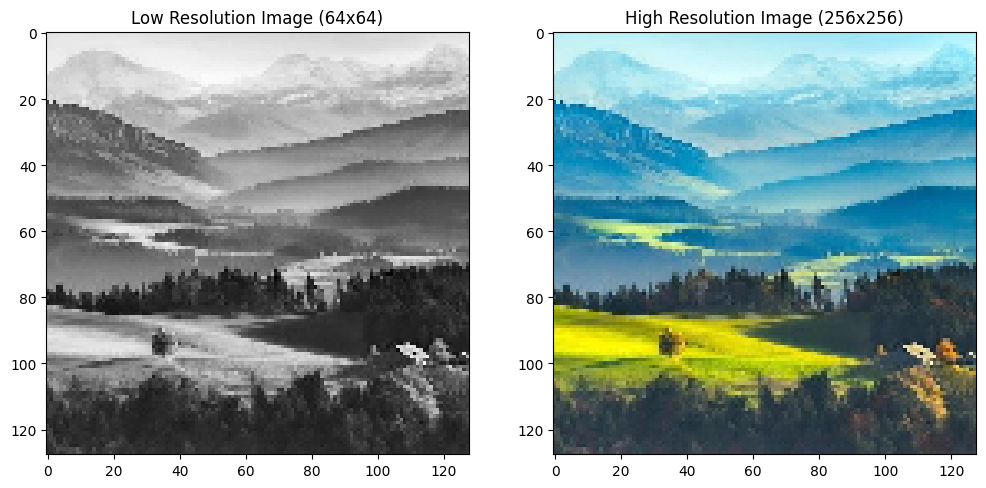

In [8]:

print("Black White Shape:", gray_images.shape)
print("Color Shape:", color_images.shape)

# Plot the first image in the batch
plt.figure(figsize=(12, 6))

# Low resolution image
plt.subplot(1, 2, 1)
plt.imshow(gray_images[0],cmap="gray")  # Display first image in batch
plt.title("Gray Scale")

# High resolution image
plt.subplot(1, 2, 2)
plt.imshow(color_images[0])  # Display first image in batch
plt.title("Color Image")

plt.show()


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

def build_upscaler():
    # Input layer (Low-resolution 64x64x3)
    inputs = Input(shape=(64, 64, 3))  # Input size: (64, 64, 3) - 64x64 image with 3 channels (RGB)

    # Initial convolution block (feature extraction)
    x = Conv2D(64, (9, 9), padding="same")(inputs)  # Convolution with a kernel of size (9, 9), 64 filters
    x = LeakyReLU(alpha=0.2)(x)  # Activation using LeakyReLU to prevent vanishing gradients
    x = BatchNormalization()(x)  # Batch normalization to stabilize training

    # Size after this block: (64, 64, 64) - The image is still 64x64, but the number of channels has increased to 64

    # Feature extraction block with more filters
    x = Conv2D(128, (5, 5), padding="same")(x)  # Convolution with kernel size (5, 5), 128 filters
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization to help with faster convergence

    # Size after this block: (64, 64, 128) - The image is still 64x64, but the number of channels is now 128

    # Upscaling to 128x128 using transposed convolutions
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 64x64 → 128x128
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (128, 128, 128) - Image size has increased to 128x128 with 128 channels

    # Further upscaling to 256x256
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 128x128 → 256x256
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (256, 256, 64) - Image size has increased to 256x256 with 64 channels

    # Residual connection to preserve fine details
    residual = Conv2D(64, (5, 5), padding="same")(x)  # Convolution to extract finer details
    residual = LeakyReLU(alpha=0.2)(residual)  # LeakyReLU activation
    residual = BatchNormalization()(residual)  # Batch normalization

    # Residual connection: Adding the original feature map to the transformed feature map
    x = Add()([x, residual])  # The residual helps preserve finer details and avoid blurriness

    # Size after this block: (256, 256, 64) - The image size stays at 256x256, but the number of channels is 64

    # Final convolution layer to output 256x256 RGB image (3 channels)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)  # Final conv: 256x256 → 256x256 with 3 channels

    # Size after this block: (256, 256, 3) - Final image size is 256x256 with 3 channels (RGB)

    # Create the model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Compile model with Adam optimizer and MSE loss

    return model

# Instantiate and summarize the model
model = build_upscaler()
model.summary()  # Summary shows the architecture details and layer output sizes


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         15,616 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 64, 64, 64)     │              0 │ conv2d_8[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 64)     │            256 │ leaky_re_lu_10[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │        204,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 64, 64, 128)    │              0 │ conv2d_9[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_11[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 128, 128, 128)  │        262,272 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_4[0]… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 256, 256, 64)   │        131,136 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 256, 256, 64)   │              0 │ conv2d_transpose_5[0]… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 256, 256, 64)   │            256 │ leaky_re_lu_13[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 256, 256, 64)   │        102,464 │ batch_normalization_1… │
├──────────────────────

 Total params: 723,011 (2.76 MB)

 Trainable params: 722,115 (2.75 MB)

 Non-trainable params: 896 (3.50 KB)

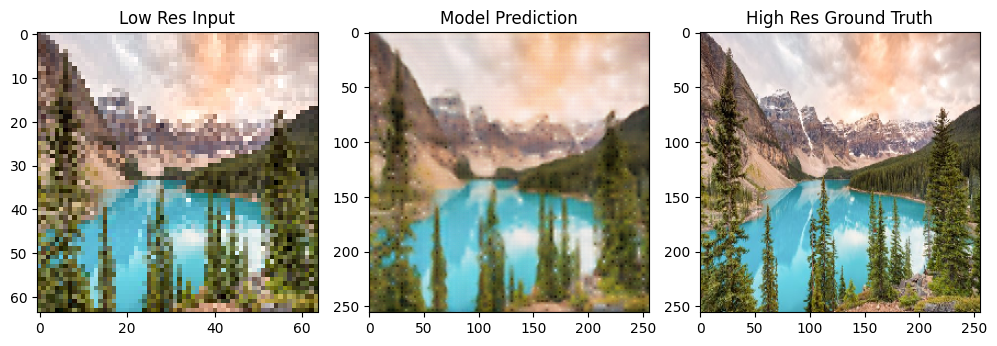

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0076 - mae: 0.0560


In [ ]:

class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def on_epoch_end(self, epoch, logs=None):

        # early stop
        current_loss = logs.get('loss')

        # Check if the loss has improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If loss hasn't improved for 'patience' epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Get a sample of the validation data
        low_res, high_res = next(iter(self.val_data))

        # Ensure low_res and high_res have a batch dimension
        low_res = tf.expand_dims(low_res, axis=0) if len(low_res.shape) == 3 else low_res
        high_res = tf.expand_dims(high_res, axis=0) if len(high_res.shape) == 3 else high_res

        # Generate prediction from the model
        pred = self.model.predict(low_res)

        # Display images
        plt.figure(figsize=(10, 5))

        # Low-resolution input
        plt.subplot(1, 3, 1)
        plt.imshow(low_res[0])  # Show first image of batch
        plt.title("Low Res Input")

        # Model prediction
        plt.subplot(1, 3, 2)
        plt.imshow(pred[0])  # Show first predicted image
        plt.title("Model Prediction")

        # High-resolution ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(high_res[0])  # Show first high-res image
        plt.title("High Res Ground Truth")

        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

# Convert to tf.data.Dataset properly if it's not in batch form yet
val_data = tf.data.Dataset.from_tensor_slices((low_res_images[:10], high_res_images[:10]))  # Use 10 samples for validation
val_data = val_data.batch(1)  # Ensure the data is batched

# Add the callback to training
callback = DisplayPrediction(val_data)
#tf.dataset olduğundan batch size yukarda
# Train the model with the callback
model.fit(dataset, epochs=150, callbacks=[callback])


In [ ]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


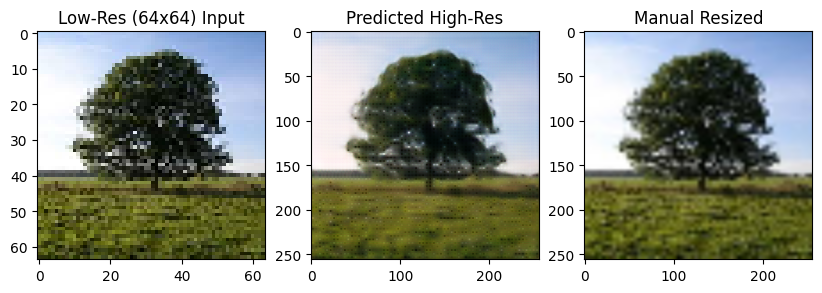

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (64, 64))


    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 3, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 3, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.subplot(1, 3, 3)
new_res=cv2.resize(low_res,(256,256))
plt.imshow(new_res)
plt.title("Manual Resized")



plt.show()



Sace and use later

In [ ]:
# Save the model in H5 format
model.save("upscaler_model.h5")


In [ ]:
loaded_model = tf.keras.models.load_model("upscaler_model.h5")

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (64, 64))

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"

# Load model (if already saved and needs to be loaded)
# model = tf.keras.models.load_model("upscaler_model.h5")

# Predict with the model
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()

# Save model for later use
model.save("upscaler_model.h5")  # Save the model